**Нюанс** — не помню, с какой именно почты подавал актуальную заявку в этому году. Хочется чтобы вы имели свежую информацию, поэтому укажу обе:
- ggusev@eu.spb.ru
- pimpmobile01@gmail.com

In [1]:
import pandas as pd
import numpy as np
import torch 
from torchvision import transforms
from torchvision.transforms import v2

import matplotlib.pyplot as plt
import seaborn as sns

import os
import random
from io import BytesIO
from PIL import Image

In [2]:
SEED = 666
PATH = '/kaggle/input/kontur/'

In [3]:
# компрессия изображения 
def randomJPEGcompression(image):
    q = random.randrange(20, 90)
    outputIoStream = BytesIO()

    image.save(outputIoStream, 'JPEG', quality=q, optimice=True)
    outputIoStream.seek(0)
    
    return Image.open(outputIoStream)

**Загрузка данных**

In [4]:
df_train_full = pd.read_csv(PATH + 'train.csv')
df_test = pd.read_csv(PATH + 'test.csv')

# у некоторых названий файлов отсутствует расширение -- это может вызвать проблемы при обращении по к файлу по пути
df_train_full['id'].apply(lambda x: '.' in x).value_counts()

id
True     846
False    166
Name: count, dtype: int64

In [5]:
# баланс классов слегка скошен
df_train_full['target'].value_counts(normalize=True)

target
0    0.659091
1    0.340909
Name: proportion, dtype: float64

In [6]:
# подтягиваем отсутствующие расширения
def _get_data(df: pd.DataFrame, dir_path: str = PATH + 'images', is_test: bool = False) -> pd.DataFrame:
    """
    Собирает датафрейм с исправленными названиями файлов.
    
    :param df:       = Датафрейм с исходными названиями файлов и таргетами
    :param dir_path: = Путь к директории где хранятся сами изображения
    :param is_test:  = Для тестовой выборки таргет не подтягивается

    :returns:        = Датафрейм с исправленными названиями файлов
    """
    file_list = []
    
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            file_list.append({file})
    
    filenames = pd.DataFrame(file_list, columns=['corrected_id'])
    
    filenames['key'] = filenames['corrected_id'].apply(lambda x: x.split('.')[0])
    df['key'] = df['id'].apply(lambda x: x.split('.')[0])
    
    if is_test:
        corrected_df = df.merge(filenames, on='key', how='inner')[['corrected_id']].copy()
    else:
        corrected_df = df.merge(filenames, on='key', how='inner')[['corrected_id', 'target']].copy()
        
    assert all(corrected_df['corrected_id'].apply(lambda x: '.' in x)), 'some file extensions are still missing'
    
    return corrected_df
    
df_train_full_corrected = _get_data(df_train_full)
df_test_corrected = _get_data(df_test, is_test=True)

print(df_train_full_corrected.shape, df_test_corrected.shape)

(1012, 2) (506, 1)


In [7]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    DEVICE = torch.device('cpu')
    print('CUDA is not available.  Training on CPU ...')
else:
    DEVICE = torch.device('cuda')
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:
df_train_full_corrected.shape, df_test_corrected.shape

((1012, 2), (506, 1))

## **Ход решения**

**Задача** — бинарная классификация изображений.

Размеченная выборка состоит из 1012 цветных (RGB, RGBA) изображений различных размеров (размер изображения здесь, кстати, обладает заметной разделяющей способностью), в дальнейшем разбивается на обучающую (80%) и валидационную (20%) выборки. 

Представленные классы — изображения, сгенерированные ИИ (y = 1, 35% размеченной выборки) и "реальные" изображения (y = 0, 65% размеченной выборки).

Работоспособность модели проверяется на тестовой выборке состоящей из 506 наблюдений.

**Наивный подход** — попытка решить задачу с помощью некой стандартной модели для классификации изображений — например, модели из семейства свёрточных нейросетей. 



**Проблема**

Далее цитируется работа [Towards Universal Fake Image Detectors that
Generalize Across Generative Models](https://arxiv.org/pdf/2302.10174.pdf)

Дело в том, что такой модели нет необходимости учиться различать реальные изображения — для снижения ошибки ей достаточно найти низкоуровневые признаки, отличающие сгенерированные изображения. Возникает проблема — даже если мы научимся различать сгенерированные изображения по этим признакам, никто не гарантирует, что упомянутые признаки не являются сугубо артефактом работы конкретной генеративной модели, создавшей изображения которые попали в обучающую выборку:

>...our hypothesis is that when model is learning to distinguish between Fake (generated by GAN) and Real it latches onto the artifacts, learning only to look for the presence/absence of those patterns in an image. Since this is sufficient for it to reduce the training error, it largely ignores learning any features (e.g., smooth edges) pertaining to the real class. This, in turn, results in a skewed decision boundary where a fake image from a diffusion model, lacking the GAN’s fingerprints, ends up being classified as real...
>

В этом случае, с точки зрения модели, отрицательный класс не будет представлять "реальные" изображения, но скорее будет вмещать все те объекты, что не обладают признаками, отличающими сгенерированные (конкретной моделью) изображения — в том числе изображения, порождённые другим семейством генеративных моделей:
>...specifically, we find that these models work (or fail to work) in a rather interesting manner. Whenever an image contains the (low-level) fingerprints particular to the generative model used for training (e.g., ProGAN), the image gets classified as fake. Anything else gets classified as real. There are two implications: (i) even if diffusion models have a fingerprint of their own, as long as it is not very similar to GAN’s fingerprint, their fake images get classified as real; (ii) **the classifier doesn’t seem to look for features of the real distribution when classifying an image as real**; instead, the real class becomes a **‘sink class’** which hosts anything that is not GAN’s version of fake image. In other words, the decision boundary for such a classifier will be closely bound to the particular fake domain...
>

Таким образом, модель будет обладать неудовлетворительной обобщающей способностью — встретив изображения, сгенированные другим семейством моделей, она классифицирует их как реальные:
> ...when the target model belongs to the same breed of generative model used for training the real-vs-fake classifier (i.e., GANs), the network shows good overall generalizability in classifying the images; e.g., GauGAN’s real/fake images can be detected with 79.25% accuracy. **However**, when tested on a different family of generative models, e.g., LDM and Guided, the classification accuracy drastically drops to near chance performance..
>

**Решение**

Почему бы не сделать наоборот? Научить модель хорошо "чувствовать" реальные изображения, а всему остальному проставлять положительный класс — таким образом модель не будет смещена в сторону конкретной модели, сгенерировавшей изображения из обучающей выборки. 

Сложность в том, что реальность многообразна и нашей обучающей выборки явно недостаточно, чтобы модель научилась эту реальность "чувствовать":
>...since we hope to design a general purpose fake image detector, its functioning should be consistent for a wide variety of real/fake images (e.g., a human face, an outdoor scene). This calls for the feature space of ϕ to be heavily populated with different kinds of images, so that for any new test image, it knows how to embed it properly...
>

Предложенное авторами решение — вместо исходных изображений использовать их эмбеддинги, полученные из некой модели, предобученной на богатой выборке, отражающей это многообразие. В этом случае классификация будет проходить в признаковом пространстве, характеризующем реальные изображения, что позволит достичь большей обобщающей способности.

**Итоговый подход:**
- Для получения эмбеддинга (вектор длины 768) изображения используется модель для сопоставления пары (изображение, текст) [CLIP:ViT-L/14](https://huggingface.co/openai/clip-vit-large-patch14), обученная на выборке из ~400 млн. изображений из интернета
- Затем на эмбеддингах обучается простейший классификатор — логистическая регрессия

**Что пробовал:**
- Расширение обучающей выборки через использование дополнительных данных из открытых источников — приводит к снижению качества
- Аугментация изображений (повороты, размытие, компрессия) — как с расширением обучающей выборки, так и с заменой исходных изображений на аугментированные — в среднем снижение качества, необходимо подбирать оптимальный набор преобразований 
- Использование иного итогового классификатора (KNN, деревья и их ансамбли), регуляризация, поиск оптимальных гиперпараметров — снижение качества
- Расширение признакового пространства — в качестве дополнительного признака для изображения использовался выход (вероятность первого класса) из простенькой CNN — незначительное увеличение качества 

**Потенциал для улучшения:**
- Использование другой модели для получения эмбеддингов ([moondream1](https://huggingface.co/vikhyatk/moondream1), [SWIN](https://github.com/microsoft/Swin-Transformer))
- Ансамблирование моделей, обученных на разных эмбеддингах: полезно, если модели для эмбеддинга учились понимать разные "грани" реальности — скажем, одна хорошо понимает человеческие лица, другая — сцены на открытом воздухе, третья — в помещениях, etc...
- Расширение признакового пространства с помощью более продвинутой модели — думаю, что если вместо простенькой CNN использовать какой-нибудь ResNet-50 со срезанным последним слоем, дообученный под нашу задачу, то качество может улучшиться 

**Получение эмбеддингов для изображений**

In [9]:
%%capture 

# загрузка модели
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer, util

encoder_model = SentenceTransformer('clip-ViT-L-14')

2024-04-21 08:32:12.190405: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 08:32:12.190511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 08:32:12.345991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
# определение набора аугментаций 
transformations = v2.Compose([
    v2.RandomChoice([
        v2.RandomRotation(degrees=(-25, 25)),
        v2.RandomHorizontalFlip(p=1),
        v2.RandomVerticalFlip(p=1)
    ]),
    v2.GaussianBlur((5, 9), sigma=(1e-3, 5.)),
    v2.Lambda(randomJPEGcompression)
])

In [11]:
%%capture

def _get_image_embeddings(df: pd.DataFrame, mode: str, path: str = PATH + 'images/') -> pd.DataFrame:
    """
    Получение эмбеддингов изображений, создание обучающей и тестовой выборок.
    
    :param df:   = Датафрейм с названиями файлов и таргетами
    :param mode: = Определяет порядок построения выборки: использовать ли аугментации, расширять ли выборку
    :param path: = Путь к директории, где хранятся сами изображения 
    
    :returns:    = Датафрейм с обучающей (эмбеддинги + таргеты) или тестовой (эмбеддинги) выборкой
    """
    rows = []
    
    for idx in range(len(df)):
        row = df.iloc[idx]
        
        path_to_img = path + row['corrected_id']       
        img = Image.open(path_to_img).convert('RGB')
        
        if mode == 'train_upsample':
            img_emb = encoder_model.encode(img)
            
            train_row = pd.DataFrame(img_emb.reshape(1, 768))
            train_row['id'] = row['corrected_id']
            train_row['target'] = row['target']
            rows.append(train_row)
            
            img_tr = transformations(img)
            # получение эмбеддинга
            img_tr_emb = encoder_model.encode(img_tr)
            
            train_row = pd.DataFrame(img_tr_emb.reshape(1, 768))
            train_row['id'] = row['corrected_id']
            train_row['target'] = row['target']
            rows.append(train_row)
            
        elif mode == 'train':
            img_tr = transformations(img)
            
            img_tr_emb = encoder_model.encode(img_tr)
            
            train_row = pd.DataFrame(img_tr_emb.reshape(1, 768))
            train_row['id'] = row['corrected_id']
            train_row['target'] = row['target']
            rows.append(train_row)
            
        elif mode == 'train_no_aug':
            img_emb = encoder_model.encode(img)
            
            train_row = pd.DataFrame(img_emb.reshape(1, 768))
            train_row['id'] = row['corrected_id']
            train_row['target'] = row['target']
            rows.append(train_row)
            
        elif mode == 'test':
            img_emb = encoder_model.encode(img)
            
            test_row = pd.DataFrame(img_emb.reshape(1, 768))
            test_row['id'] = row['corrected_id']
            
            rows.append(test_row)

    embeddings_df = pd.concat(rows)
    
    return embeddings_df

# df_train_full_upsample = _get_image_embeddings(df_train_full_corrected, mode='train_upsample')
df_train_full_no_aug = _get_image_embeddings(df_train_full_corrected, mode='train_no_aug')

df_test = _get_image_embeddings(df_test_corrected, mode='test')

In [14]:
print(df_train_full_no_aug.shape, df_test.shape)

(1012, 770) (506, 769)


**Разделяющая способность эмбеддингов**
- выглядит обещающе 

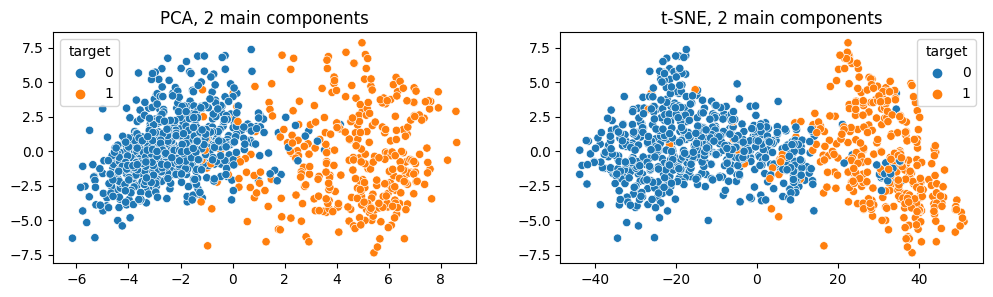

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
tsne = TSNE()

components_pca = pca.fit_transform(df_train_full_no_aug.iloc[:, :-2])
components_tsne = tsne.fit_transform(df_train_full_no_aug.iloc[:, :-2])

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].title.set_text('PCA, 2 main components')
sns.scatterplot(
    x=components_pca[:, 0], y=components_pca[:, 1],
    hue=df_train_full_no_aug['target'],
    legend='full',
    ax=axes[0]
)
axes[1].title.set_text('t-SNE, 2 main components')
sns.scatterplot(
    x=components_tsne[:, 0], y=components_pca[:, 1],
    hue=df_train_full_no_aug['target'],
    legend='full',
    ax=axes[1]
);

**Обучение**
- **Итоговая модель:** простейшая логистическая регрессия, обученная на объединённых (train + val) данных без аугментаций 

In [16]:
# df = df_train_full_upsample
df = df_train_full_no_aug

In [17]:
df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,id,target
0,-0.338056,0.178484,-0.335943,1.358259,-0.2874,-0.216652,-0.026304,0.281364,-0.141047,-0.225728,...,-0.429129,0.564752,0.180757,0.153773,-0.393303,-0.415624,-0.745382,0.897107,gL5fWrgNPU.jpg,0


In [18]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, stratify=df['target'], random_state=SEED, test_size=.2)

X_train = df_train.iloc[:, :-2]
X_val = df_val.iloc[:, :-2]

y_train = df_train['target']
y_val = df_val['target']

In [19]:
# стандартизируем признаки для более эффективной сходимости 
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [20]:
# обучаем простую модель
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

lr_model = LogisticRegression(n_jobs=-1)

lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_val_scaled)

0.9852216748768473


**Оценка качества**
- я бы смотрел на recall — важнее не пропускать сгенерированные изображения

In [47]:
def _score_model(y_true: pd.Series, y_pred: np.array) -> None:
    """
    Расчёт и вывод метрик качества модели: accuracy, precision, recall, f1-score.
    
    :param y_true: = Истинные метки классов
    :param y_pred: = Предсказанные метки классов 
    
    :returns:      = Вывод рассчитанных метрик
    """
    true_positives = ((y_pred == 1) & (y_pred == y_true)).sum()
    true_negatives = ((y_pred == 0) & (y_pred == y_true)).sum()

    false_positives = ((y_pred == 1) & (y_pred != y_true)).sum()
    false_negatives = ((y_pred == 0) & (y_pred != y_true)).sum()

    accuracy = round((true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives), 3)
    precision = round(true_positives / (true_positives + false_positives), 3)
    recall = round(true_positives / (true_positives + false_negatives), 3)
    f1 = round(2 * precision * recall / (precision + recall), 3)

    print(f"""
        Accuracy: {accuracy}
        Precision: {precision}
        Recall: {recall}
        f1-score: {f1}
        """)

In [43]:
_score_model(y_val, y_pred)


        Accuracy: 0.985
        Precision: 0.985
        Recall: 0.971
        f1-score: 0.978
        


**Когда мы ошибаемся?**
- когда на изображении не видно анфас человека
- при обучении на полной выборке этой ошибки не будет

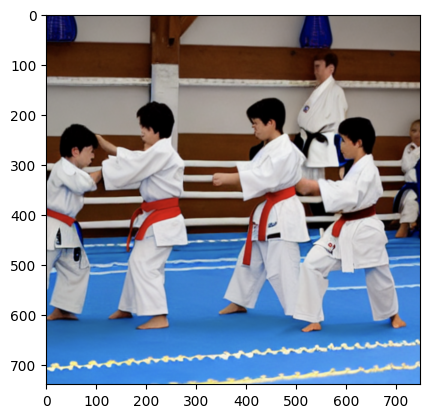

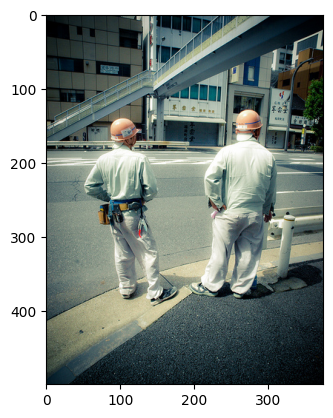

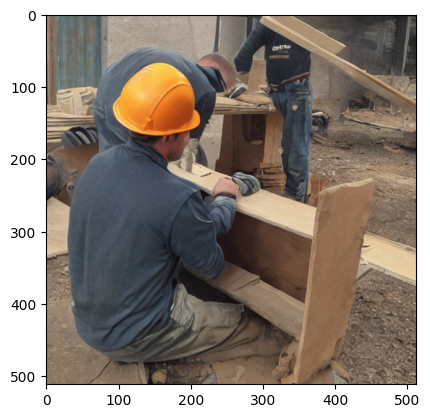

In [31]:
error_idxs = np.argwhere((y_pred != y_val)).flatten()

for img_name in df_val.iloc[error_idxs, -2].values:
    with Image.open(PATH + 'images/' + img_name) as img:
        plt.imshow(img)
        plt.show()

**Обучение модели на полной выборке**

In [50]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

full_train_scaler = StandardScaler()
full_train_scaler.fit(X_train_full)

X_train_full_scaled = full_train_scaler.transform(X_train_full)

lr_model_full = LogisticRegression(n_jobs=-1)
lr_model_full.fit(X_train_full_scaled, y_train_full)

LogisticRegression(n_jobs=-1)

Обучение на полной выборке сводит ошибку (на обучении) к нулю:

In [51]:
y_pred_full = lr_model_full.predict(X_train_full)

_score_model(y_train_full, y_pred_full)


        Accuracy: 1.0
        Precision: 1.0
        Recall: 1.0
        f1-score: 1.0
        


**Подготовка предсказаний**

In [52]:
X_test = df_test.iloc[:, :-1]
X_test_scaled = full_train_scaler.transform(X_test)

# вытаскиваем вероятность 1-го класса
y_pred_prob_test = lr_model_full.predict_proba(X_test_scaled)[:, 1]

submission_df = pd.read_csv('/kaggle/input/kontur/sample_submission.csv')
submission_df['target'] = y_pred_prob_test

submission_df.to_csv('final_submission.csv', index=False)

**################################################################################################################################################**

### Наивный подход
- неактуально

In [23]:
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.optim import lr_scheduler

# import torch.nn as nn
# import torch.nn.functional as F

# from torch.utils.data import Dataset, DataLoader, ConcatDataset
# from torch.utils.data.sampler import WeightedRandomSampler

# from tqdm.notebook import tqdm
# from collections import Counter

In [24]:
# train_on_gpu = torch.cuda.is_available()

# if not train_on_gpu:
#     DEVICE = torch.device("cpu")
#     print('CUDA is not available.  Training on CPU ...')
# else:
#     DEVICE = torch.device("cuda")
#     print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


**Загрузка и предобработка данных**

In [25]:
# RESCALE_SIZE = 224

# # предобработка и аугментация:
# transform_dict = {
#     'train': v2.Compose([
#         v2.RandomChoice([
#             v2.RandomRotation(degrees=(-25, 25)),
#             v2.RandomHorizontalFlip(p=1),
#             v2.RandomVerticalFlip(p=1)
#         ]),
#         v2.GaussianBlur((5, 9), sigma=(1e-3, 5.)),
#         v2.Lambda(randomJPEGcompression),
#         v2.Resize((RESCALE_SIZE, RESCALE_SIZE)),
#         v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
#         v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': v2.Compose([
#         v2.Resize((RESCALE_SIZE, RESCALE_SIZE)),
#         v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
#         v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'test': v2.Compose([
#         v2.Resize((RESCALE_SIZE, RESCALE_SIZE)),
#         v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
#         v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'predict_train': v2.Compose([
#         v2.RandomChoice([
#             v2.RandomRotation(degrees=(-25, 25)),
#             v2.RandomHorizontalFlip(p=1),
#             v2.RandomVerticalFlip(p=1)
#         ]),
#         v2.GaussianBlur((5, 9), sigma=(1e-3, 5.)),
#         v2.Lambda(randomJPEGcompression),
#         v2.Resize((RESCALE_SIZE, RESCALE_SIZE)),
#         v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
#         v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'predict_val':v2.Compose([
#         v2.Resize((RESCALE_SIZE, RESCALE_SIZE)),
#         v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
#         v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
# }

**Класс для загрузки изображений**

In [26]:
# class MyDataset(torch.utils.data.Dataset):
#     def __init__(self, dataframe: pd.DataFrame, mode: str) -> None:
#         self.dataframe = dataframe
#         self.mode = mode

#     def __len__(self) -> int:
#         return len(self.dataframe)

#     def __getitem__(self, index: int) -> tuple[torch.Tensor, int]:
#         row = self.dataframe.iloc[index]
        
#         path_to_img = '/kaggle/input/kontur/images/' + row['corrected_id']
        
#         # некоторые изображения в rgba, поэтому используется .convert
#         img = Image.open(path_to_img).convert('RGB')

#         # предобработка и аугментация
#         transform = transform_dict[self.mode]
#         x = transform(img)
        
#         if self.mode in ('test', 'predict_train', 'predict_val'):
#             return x
#         else:
#             y = row['target']
#             return x, y

In [27]:
# train, val = train_test_split(df_train_full_corrected, stratify=df_train_full_corrected['target'], test_size=.2, random_state=SEED)

# # здесь --- объединяем аугментированные изображения с исходными ~ расширяем обучающую выборку 
# # train_dataset = ConcatDataset([
# #     # изображения с аугментацией 
# #     MyDataset(train, mode='train'),
# #     # изображения без аугментаций
# #     MyDataset(train, mode='val')
# # ])

# # без дополнительных аугментаций
# train_dataset = MyDataset(train, mode='val')
# val_dataset = MyDataset(val, mode='val')
# test_dataset = MyDataset(df_test_corrected, mode='test')

# print(train_dataset.__len__(), val_dataset.__len__(), test_dataset.__len__())

809 203 506


**Определение процесса обучения**

In [28]:
# # триггер для ранней остановки обучения
# class EarlyStopper:
#     def __init__(self, patience=1, min_delta=0):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.counter = 0
#         self.min_validation_loss = float('inf')

#     def early_stop(self, validation_loss):
#         if validation_loss < self.min_validation_loss:
#             self.min_validation_loss = validation_loss
#             self.counter = 0
#         elif validation_loss > (self.min_validation_loss + self.min_delta):
#             self.counter += 1
#             if self.counter >= self.patience:
#                 return True
#         return False

In [52]:
# class DefineTraining():
#     def __init__(
#         self,
#         model,
#         criterion,
#         optimizer,
#         scheduler,
#         early_stopper,
#         epochs,
#         batch_size,
#         train_dataset,
#         val_dataset,
#         test_dataset,
#         use_weighted_sampling=False,
#         early_stop = False
#     ) -> None:
#         self.model = model
#         self.criterion = criterion 
#         self.optimizer = optimizer
#         self.scheduler = scheduler
#         self.early_stopper = early_stopper
#         self.early_stop = early_stop
        
#         self.epochs = epochs 
#         self.batch_size = batch_size
        
#         self.train_dataset = train_dataset
#         self.val_dataset = val_dataset
#         self.test_dataset = test_dataset
        
#         self.train_loader = None
#         self.val_loader = None
#         self.test_loader = None
        
#         # подготовка data-loader'ов
#         if use_weighted_sampling:
#             weighted_sampler_train = self._get_weighted_sampler(self.train_dataset, train)
#             weighted_sampler_val = self._get_weighted_sampler(self.val_dataset, val)
#             self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, sampler=weighted_sampler_train, num_workers=2)
#             self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, sampler=weighted_sampler_val, num_workers=2, shuffle=False)
#         else:
#             self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=2, shuffle=True)
#             self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=2, shuffle=False)
                
#         self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=2)
    
#     # обучение внутри эпохи
#     def fit_epoch(self, model, train_loader, criterion, optimizer, scheduler) -> tuple[float, float]:
#         running_loss = 0.0
#         running_corrects = 0
#         processed_data = 0

#         model.train()

#         for inputs, labels in train_loader:
#             inputs = inputs.to(DEVICE)
#             labels = labels.to(DEVICE)

#             optimizer.zero_grad()

#             outputs = model(inputs)

#             loss = criterion(outputs, labels)
#             loss.backward()

#             optimizer.step()

#             preds = torch.argmax(outputs, 1)
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)
#             processed_data += inputs.size(0)

#         scheduler.step()
        
#         train_loss = running_loss / processed_data
#         train_acc = running_corrects.cpu().numpy() / processed_data
        
#         return train_loss, train_acc
    
#     # валидация внутри эпохи
#     def eval_epoch(self, model, val_loader, criterion) -> tuple[float, float]:
#         running_loss = 0.0
#         running_corrects = 0
#         processed_size = 0

#         model.eval()

#         for inputs, labels in val_loader:
#             inputs = inputs.to(DEVICE)
#             labels = labels.to(DEVICE)

#             with torch.set_grad_enabled(False):
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 preds = torch.argmax(outputs, 1)

#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)
#             processed_size += inputs.size(0)

#         val_loss = running_loss / processed_size
#         val_acc = running_corrects.double() / processed_size

#         return val_loss, val_acc    
    
#     # запуск обучения 
#     def train(self):
#         history = []
#         log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
#         val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"


#         with tqdm(desc="epoch", total=self.epochs) as pbar_outer:
#             for epoch in range(self.epochs):
#                 train_loss, train_acc = self.fit_epoch(self.model, self.train_loader, self.criterion, self.optimizer, self.scheduler)
#                 print("loss", train_loss)

#                 val_loss, val_acc = self.eval_epoch(self.model, self.val_loader, self.criterion)

#                 if self.early_stop and self.early_stopper.early_stop(val_loss): 
#                     print('early stopping...')
#                     break
                    
#                 history.append((train_loss, train_acc, val_loss, val_acc))

#                 pbar_outer.update(1)
#                 tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
#                                                v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

#         return history
    
#     # прогноз
#     def predict(self) -> np.ndarray[float]:
#         with torch.no_grad():
#             logits = []

#             for inputs in self.test_loader:
#                 inputs = inputs.to(DEVICE)
#                 self.model.eval()
#                 outputs = self.model(inputs).cpu()
#                 logits.append(outputs)
                
#         probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

#         return probs[:, 1]
        
#     # взвешенное сэмплирование    
#     def _get_weighted_sampler(self, dataset, df):
#         class_counts = Counter(df['target'])
#         class_weights = {i: 1 / count for i, count in class_counts.items()}
#         sample_weights = [0] * len(dataset)

#         for i, label in enumerate(df['target']):
#             class_weight = class_weights[label]
#             sample_weights[i] = class_weight

#         N = max(class_counts.values()) * len(class_counts)

#         return WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

**Определение модели**

In [35]:
# class MyCnn(nn.Module):
#     def __init__(self, n_classes):
#         super().__init__()
        
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
#             nn.BatchNorm2d(8, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
#             nn.BatchNorm2d(16, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
#             nn.BatchNorm2d(32, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#             nn.BatchNorm2d(64, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
#             nn.BatchNorm2d(96, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.fl = nn.Flatten()
#         self.out = nn.Linear(96 * 5 * 5, n_classes, bias=True)
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.conv5(x)
        
#         x = self.fl(x)
#         logits = self.out(x)

#         return logits

**Обучение**

In [53]:
# n_classes = len(np.unique(df_train_full_corrected['target']))
# my_cnn = MyCnn(n_classes).to(DEVICE)

# print("we will classify {} classes".format(n_classes))
# print(my_cnn)

we will classify 2 classes

MyCnn(

  (conv1): Sequential(

    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))

    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): LeakyReLU(negative_slope=0.01)

    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

  )

  (conv2): Sequential(

    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))

    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): LeakyReLU(negative_slope=0.01)

    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

  )

  (conv3): Sequential(

    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))

    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): LeakyReLU(negative_slope=0.01)

    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

  )

  (conv4): Sequential(

    (0): Conv2d(32, 64, kerne

In [54]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(my_cnn.parameters(), lr=1e-3, amsgrad=True)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# early_stopper = EarlyStopper(patience=5, min_delta=.1)

# training_routine = DefineTraining(
#     my_cnn,
#     criterion,
#     optimizer,
#     scheduler,
#     early_stopper,
#     15,
#     64,
#     train_dataset,
#     val_dataset,
#     test_dataset,
#     use_weighted_sampling=True,
#     early_stop=False
# )

In [ ]:
# history = training_routine.train()

In [ ]:
# # визуализация процесса обучения модели
# loss, acc, val_loss, val_acc = zip(*history)

# plt.figure(figsize=(15, 9))
# plt.plot(loss, label="train_loss")
# plt.plot(val_loss, label="val_loss")
# plt.legend(loc='best')
# plt.xlabel("epochs")
# plt.ylabel("loss")
# plt.show()

**Предсказание и загрузка результата**

In [57]:
# probs = training_routine.predict()

# submission_df = pd.read_csv('/kaggle/input/kontur/sample_submission.csv')
# submission_df['target'] = probs

# submission_df.to_csv('bad_submission.csv', index=False)